In [1]:
import networkit as nk
import networkx as nx
# import girg_sampling.girgs as girgs
import matplotlib.pyplot as plt
import numpy as np

from benji_girgs import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import re
import glob
from tqdm import tqdm
import os

In [8]:
os.listdir('/Users/benjidayan/Downloads/wikipedia_link_ro/out.wikipedia_link_ro')

NotADirectoryError: [Errno 20] Not a directory: '/Users/benjidayan/Downloads/wikipedia_link_ro/out.wikipedia_link_ro'

<Figure size 1200x600 with 0 Axes>

Calculating best minimal value for power law fit
powerlaw alpha: 1.988


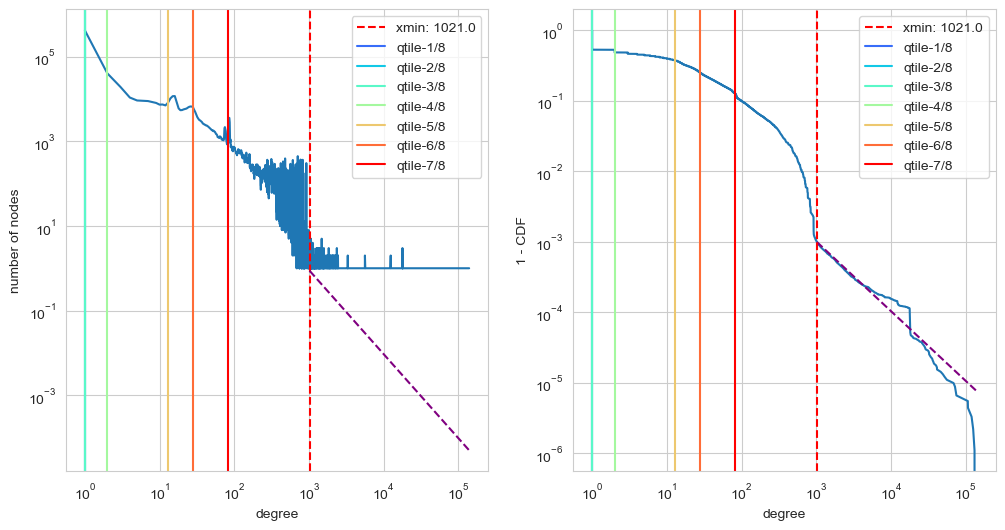

In [116]:
path = '/Users/benjidayan/Downloads/wikipedia_link_ro/out.wikipedia_link_ro'
g = nk.readGraph(path, nk.Format.EdgeListTabOne)
plt.figure(figsize=(12, 6))
plot_degree_dist(g, vlines=8, pl_fit=True)

<Figure size 1200x600 with 0 Axes>

Calculating best minimal value for power law fit
powerlaw alpha: 2.986


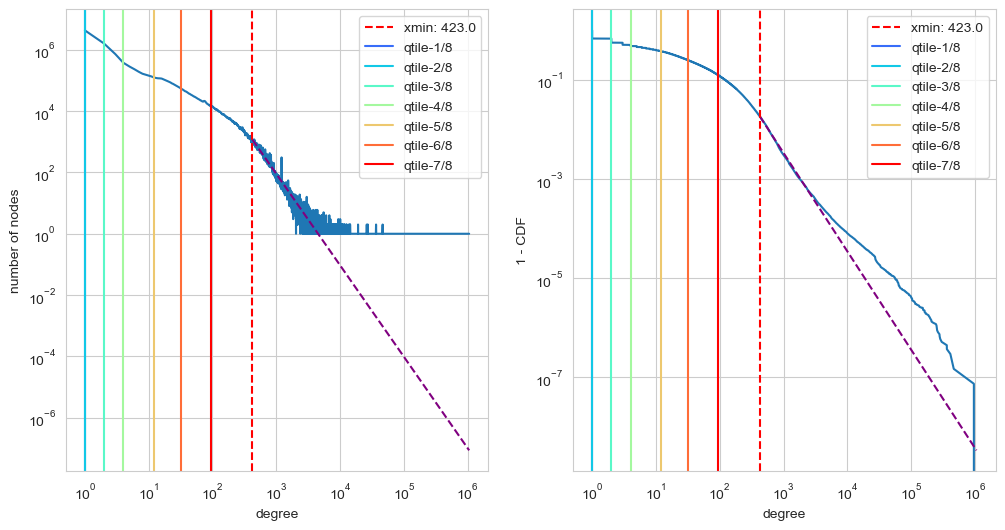

In [13]:
path = '/Users/benjidayan/Downloads/wikipedia_link_en/out.wikipedia_link_en'
g = nk.readGraph(path, nk.Format.EdgeListTabOne)
plt.figure(figsize=(12, 6))
plot_degree_dist(g, vlines=8, pl_fit=True)

In [14]:
print(g.numberOfNodes())

13593032


(array([  57.,  166.,  368.,  639.,  987., 1328., 1611., 1794., 1822.,
        1228.]),
 array([0.09106494, 0.28188885, 0.47271275, 0.66353666, 0.85436057,
        1.04518447, 1.23600838, 1.42683228, 1.61765619, 1.8084801 ,
        1.999304  ]),
 <BarContainer object of 10 artists>)

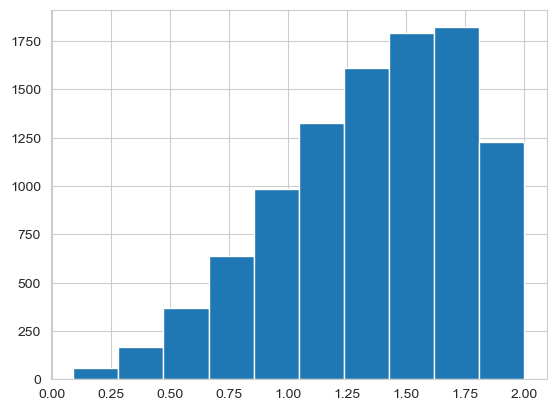

In [37]:
n = 10000
d = 4
r = 
units = np.random.normal(size=(n, d))
units = np.stack([r * x/np.linalg.norm(x) for x in units])
evec = np.array([1.0] + [0.0]*(d-1))
dists = np.stack([np.linalg.norm(evec-unit) for unit in units])
plt.hist(dists)

In [51]:
# n = wiki.numberOfNodes()
n=5000
d=2
tau=2.483
alpha=4.0
wikigirg, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)
nk.overview(wikigirg)

/Users/benjidayan/My Drive/eth_courses/GIRG/benji_src/benji_girgs.py:183: RuntimeWarning: divide by zero encountered in divide
  return p_uv


Network Properties:
nodes, edges			5000, 107804
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.008626
clustering coefficient		0.718588
min/max/avg degree		5, 3089, 43.121600
degree assortativity		-0.088835
number of connected components	1
size of largest component	5000 (100.00 %)


In [45]:
degrees = [wikigirg.degree(i) for i in range(wikigirg.numberOfNodes())]
degrees[:10]
weights[:10]

[16, 84, 9, 20, 15, 54, 10, 22, 71, 12]

array([1.0944641 , 5.71339798, 1.02666205, 1.04682869, 1.44151859,
       4.46009157, 1.03626303, 1.50785317, 4.90497938, 1.13073561])

In [81]:
# n = wiki.numberOfNodes()
n=5000
d=2
tau=2.483
alpha=1.2
g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)
nk.overview(g)

mean_weight = np.mean(weights)
mean_weight
dists = get_dists_julia(pts, n**(1/d))

avg_weight_of_far_neighbours = []

for i in range(g.numberOfNodes()):
    weight = weights[i]
    neighbours = np.array([pair[0] for pair in list(enumerate(edges[i])) if pair[1]])
    if len(neighbours) > 1:
        neighbour_dists = dists[i, neighbours]
        neighbour_weights = weights[neighbours]
        far_neighbours = neighbours[neighbour_dists > (weight * mean_weight)**(1/d)]
        avg_weight_of_far_neighbours.append(np.mean(weights[far_neighbours]))

/Users/benjidayan/My Drive/eth_courses/GIRG/benji_src/benji_girgs.py:183: RuntimeWarning: divide by zero encountered in divide
  return p_uv


Network Properties:
nodes, edges			5000, 287539
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.023008
clustering coefficient		0.354679
min/max/avg degree		33, 4999, 115.015600
degree assortativity		-0.085258
number of connected components	1
size of largest component	5000 (100.00 %)


3.2504990529277538

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [103]:
def sample_edge_stuff(g, num_edges):
    cni = nk.linkprediction.CommonNeighborsIndex(g)

    edges = list(g.iterEdges())
    degrees = np.array([g.degree(node) for node in g.iterNodes()]).astype(np.int64)
    stuff = []
    lambdas = np.arange(0.1, 1.0, 0.1)
    for i in np.random.choice(len(edges), num_edges):
        a, b = edges[i]
        degs = [g.degree(a), g.degree(b)]
        if degs[0] > degs[1]:
            a, b = b, a
        dist = get_dists(np.stack([pts[a], pts[b]]), n**(1/d))[0, 1]

        a_nhbs = np.array(list(g.iterNeighbors(a)))
        b_nhbs = np.array(list(g.iterNeighbors(b)))
        a_weights = degrees[a_nhbs]
        lambda_intersects = []
        for l in lambdas:
            a_big_nhbs = a_nhbs[a_weights > degrees[a] * l]
            lambda_intersects.append(
                (l, 
                 len(set(b_nhbs).intersection(set(a_big_nhbs)))/len(a_big_nhbs)
                )
            )
        stuff.append((min(degs), max(degs), int(cni.run(a, b)), dist, lambda_intersects))
        

    return stuff


def sample_edge_stuff2(g, num_edges):
    stuff = sample_edge_stuff(g, num_edges)
    degrees = np.array([g.degree(node) for node in g.iterNodes()]).astype(np.int64)
    qs = np.quantile([g.degree(node) for node in g.iterNodes()], [0.15, 0.5, 0.85])
    return [x for x in stuff if x[0] < qs[0] and x[1] > qs[-1] ]


def get_common_nb_percs(g, num_edges):
    stuff = sample_edge_stuff(g, num_edges)
    return [x[2]/x[0] for x in stuff]

def get_common_nb_percs2(g, num_edges):
    stuff = sample_edge_stuff(g, num_edges)
    return [x[2]/x[0] for x in stuff]


def sample_possible_triangles(g, num_triangles):
    nodes = list(g.iterNodes())
    stuff = []
    for c in np.random.choice(nodes, num_triangles):
        c_deg = g.degree(c)
        if c_deg < 2:
            continue
    
        c_nhbs = list(g.iterNeighbors(c))
        a, b = np.random.choice(len(c_nhbs), 2, replace=False)
        a, b = c_nhbs[a], c_nhbs[b]

        a_deg, b_deg= g.degree(a), g.degree(b)
        stuff.append((a_deg, b_deg, c_deg, g.hasEdge(a, b)))

    return stuff



0.1998416050686378
Network Properties:
nodes, edges			2000, 56693
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.028361
clustering coefficient		0.594033
min/max/avg degree		13, 1999, 56.693000
degree assortativity		-0.121578
number of connected components	1
size of largest component	2000 (100.00 %)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.2105654761904762
Network Properties:
nodes, edges			2000, 55362
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.027695
clustering coefficient		0.582469
min/max/avg degree		10, 1574, 55.362000
degree assortativity		-0.114979
number of connected components	1
size of largest component	2000 (100.00 %)
0.20371912295309463
Network Properties:
nodes, edges			2000, 61527
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.030779
clustering coefficient		0.608478
min/max/avg degree		11, 1901, 61.527000
degree assortativity		-0.139063
number of connected components	1
size of largest component	2000 (100.00 %)
0.19679633867276888
Network Properties:
nodes, edges			2000, 56678
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.028353
clustering coefficient		0.575269
min/max/avg degree		11, 1319, 56.678000
degree assortativity		-0.111924
number of connected components	1
size of largest component	2000 (

<Figure size 640x480 with 0 Axes>

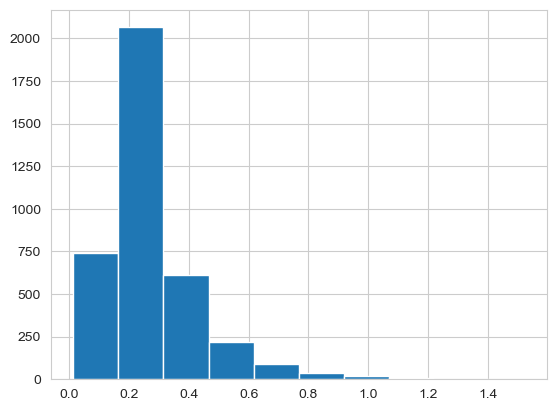

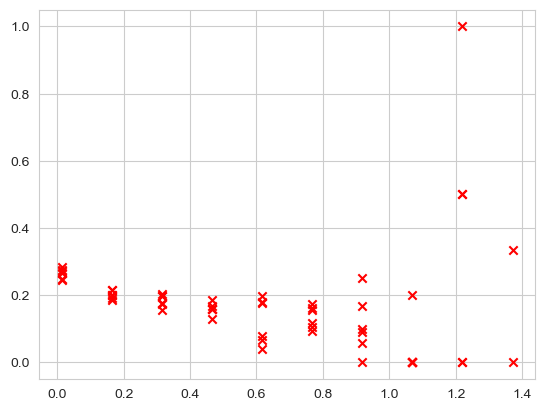

In [112]:
n=2000
d=2
tau=2.483
alpha=2.0

g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)

stuff = sample_possible_triangles(g, 30000)
stuff = [x for x in stuff if x[2] > x[1] and x[2] > x[0]]
cc = np.mean([x[3] for x in stuff])
print(cc)
nk.overview(g)
def f(a, b, c):
    ratios = [a/c, b/c]
    max_i = np.argmax(ratios)
    return ratios[max_i] * (1/d) * np.log(1/ratios[0 if max_i else 1])

# y, bins, _ = plt.hist([max(b_deg/c_deg, a_deg/c_deg) for a_deg, b_deg, c_deg, _ in stuff], bins=10)
y, bins, _ = plt.hist([f(a,b,c) for a, b, c, _ in stuff], bins=10)

outs = [[] for _ in range(len(bins) -1) ]
for a_deg, b_deg, c_deg, a_b in stuff:
    i = bisect.bisect_left(bins, f(a_deg, b_deg, c_deg)) -1
    outs[i].append(a_b)

final = [[np.mean(bin) for bin in outs]]

for _ in range(5):
    g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)

    stuff = sample_possible_triangles(g, 30000)
    stuff = [x for x in stuff if x[2] > x[1] and x[2] > x[0]]
    cc = np.mean([x[3] for x in stuff])
    print(cc)
    nk.overview(g)

    # y, bins, _ = plt.hist([max(b_deg/c_deg, a_deg/c_deg) for a_deg, b_deg, c_deg, _ in stuff], bins=10)
    outs = [[] for _ in range(len(bins) -1) ]
    for a_deg, b_deg, c_deg, a_b in stuff:
        i = bisect.bisect_left(bins, f(a_deg, b_deg, c_deg)) -1
        if i >= 0 and i < len(outs):
            outs[i].append(a_b)

    final.append([[np.mean(bin) for bin in outs]])

plt.figure()
for thing in final:
    plt.scatter(bins[:-1], thing, color='r', marker='x')
    

In [98]:
outs[0] == outs[1]

True

In [87]:
import bisect
dir(bisect)
bisect.bisect_right([10, 23, 27, 32], 27)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect',
 'bisect_left',
 'bisect_right',
 'insort',
 'insort_left',
 'insort_right']

3

In [62]:
n=5000
d=2
tau=2.483
alpha=2.0

g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)

stuff = sample_edge_stuff2(g, 800)


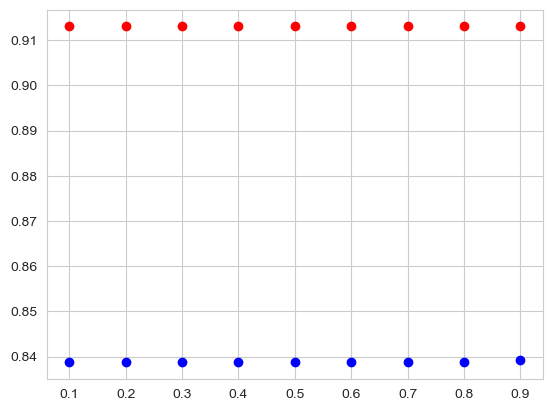

In [61]:
lambda_stuff = np.array([x[4] for x in stuff])
means = np.mean(lambda_stuff, axis=0)
medians = np.median(lambda_stuff, axis=0)
plt.scatter(means[:, 0], means[:, 1], color='b')
plt.scatter(medians[:, 0], medians[:, 1], color='r')

In [52]:
np.quantile(weights, [0.15, 0.5, 0.85])

array([1.10832675, 1.58337524, 3.54784208])

In [8]:
weights[list(g.iterNeighbors(a))]

array([ 6.13430564, 11.55684852,  9.69599697,  1.05755498, 72.85201238,
       46.38245502, 22.60478471,  7.40341442,  5.34599891,  5.84195035,
       23.21355336,  2.22215349,  3.57739603,  1.16178935,  2.52573391,
        5.35648055,  4.95318781, 75.78036193,  1.59393066,  2.3078609 ,
        3.42063659,  8.30940893,  2.05611258,  3.7766847 ,  1.87108861,
       75.25255135])

/Users/benjidayan/My Drive/eth_courses/GIRG/benji_src/benji_girgs.py:183: RuntimeWarning: divide by zero encountered in divide
  return p_uv


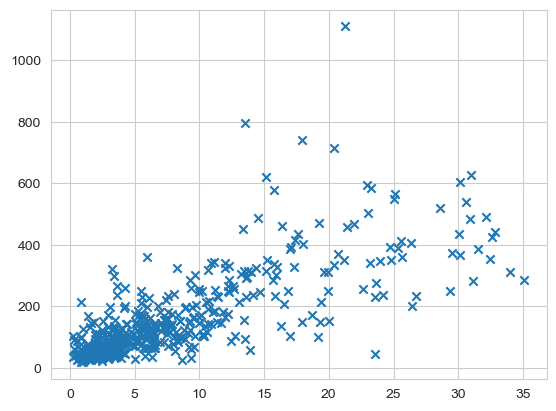

In [138]:
n=5000
d=2
tau=2.483
alpha=2.0

g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)

stuff = sample_edge_stuff(g, 500)
dists = [x[3] for x in stuff]
r_threshs = [(x[1] * x[0])**((1/d)) for x in stuff]
plt.scatter(dists, r_threshs, marker='x')
# plt.hist(dists)

In [137]:
stuff[0]

(59, 273, 44, 4.475568439549178)

In [114]:
n=1000
d=2
tau=2.5
alphas = np.arange(1.1, 10.0, 0.4)
outs = []

for alpha in tqdm(alphas):
    for _ in range(3):
        g, edges, weights, pts = generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)
        percs = get_common_nb_percs(g, 500)
        outs.append((alpha, np.median(percs)))


# plt.scatter([out[0] for out in outs], [out[1] for out in outs])

100%|██████████| 23/23 [00:08<00:00,  2.56it/s]


Text(0.5, 0, 'alpha')

Text(0, 0.5, 'median % common neighbours')

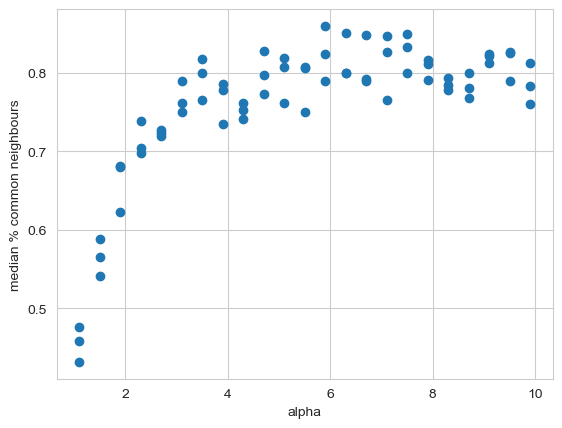

In [115]:
plt.scatter([out[0] for out in outs], [out[1] for out in outs])
plt.xlabel('alpha')
plt.ylabel('median % common neighbours')

In [99]:
percs = [triple[2]/triple[0] for triple in stuff]
percs

[0.6527777777777778,
 0.5194805194805194,
 0.5645161290322581,
 0.2727272727272727,
 0.5513428120063191,
 0.17708333333333334,
 0.5087719298245614,
 0.1796875,
 0.8181818181818182,
 0.16233766233766234,
 0.4569377990430622,
 0.4116161616161616,
 0.7666666666666667,
 0.7884615384615384,
 0.43333333333333335,
 0.5679012345679012,
 0.21935483870967742,
 0.3582089552238806,
 0.8105263157894737,
 0.4823529411764706]